In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, f1_score, 
                             precision_score, recall_score, accuracy_score, 
                             roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load Data
#-----------------------------------------
data = pd.read_csv('processed_fraud_data.csv')  # Adjust the path/filename as needed

# Separate features and target
drop_cols = ['class', 'user_id', 'signup_time', 'purchase_time', 'device_id']
X = data.drop(columns=[col for col in drop_cols if col in data.columns], errors='ignore')
y = data['class']

# Scale numeric features (SVC and boosting might benefit from scaling)
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [3]:
# 2. Train/Test Split
#-----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)


In [4]:
# 3. Handle Class Imbalance (SMOTE)
#-----------------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [7]:
# 4. Define New Models
#-----------------------------------------
models = {
    # "SVC": SVC(probability=True, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Parameter grids for GridSearchCV
param_grids = {
    # "SVC": {
    #     'C': [0.1, 1, 10],
    #     'kernel': ['rbf', 'linear', 'poly'],
    #     'class_weight': [None, 'balanced']
    # },
    "GradientBoosting": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 300],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}


In [10]:
# 5. Hyperparameter Tuning using GridSearchCV
#-----------------------------------------
best_models = {}

for model_name, model in models.items():
    print(f"Training and tuning {model_name} using GridSearchCV...")
    grid = GridSearchCV(model, param_grids[model_name], scoring='f1', cv=3, n_jobs=-1, verbose=3)
    grid.fit(X_train_res, y_train_res)
    best_models[model_name] = grid.best_estimator_
    print(f"Best params for {model_name}: {grid.best_params_}\n")

Training and tuning GradientBoosting using GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}

Training and tuning AdaBoost using GridSearchCV...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best params for AdaBoost: {'learning_rate': 0.2, 'n_estimators': 300}



In [11]:
# 6. Evaluate Each Model
#-----------------------------------------
model_scores = []
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    model_scores.append((model_name, accuracy, precision, recall, f1))

    print(f"Metrics for {model_name}:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("----------------------------------------------------\n")

Metrics for GradientBoosting:
Accuracy:  0.9554
Precision: 0.9933
Recall:    0.5269
F1-Score:  0.6885

Confusion Matrix:
[[27383    10]
 [ 1339  1491]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.99      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

----------------------------------------------------

Metrics for AdaBoost:
Accuracy:  0.9556
Precision: 0.9967
Recall:    0.5272
F1-Score:  0.6896

Confusion Matrix:
[[27388     5]
 [ 1338  1492]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
wei

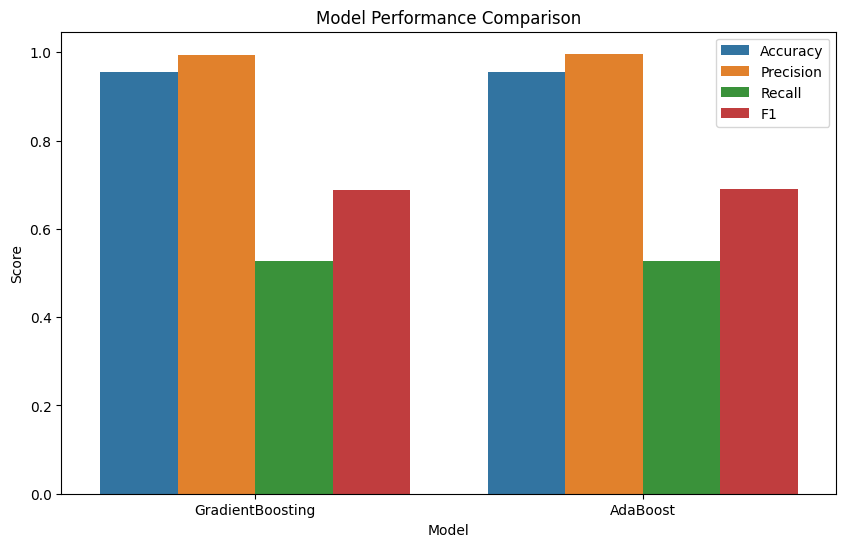

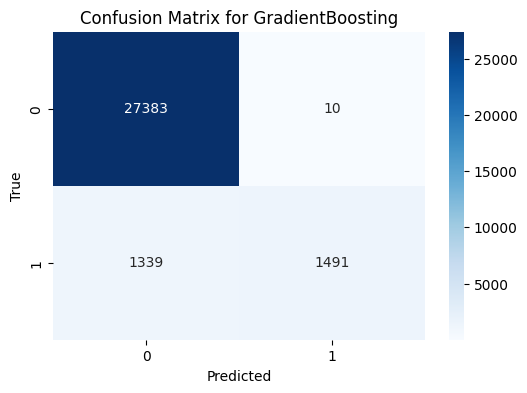

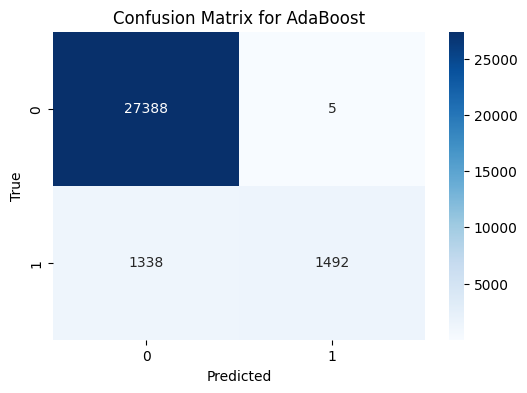

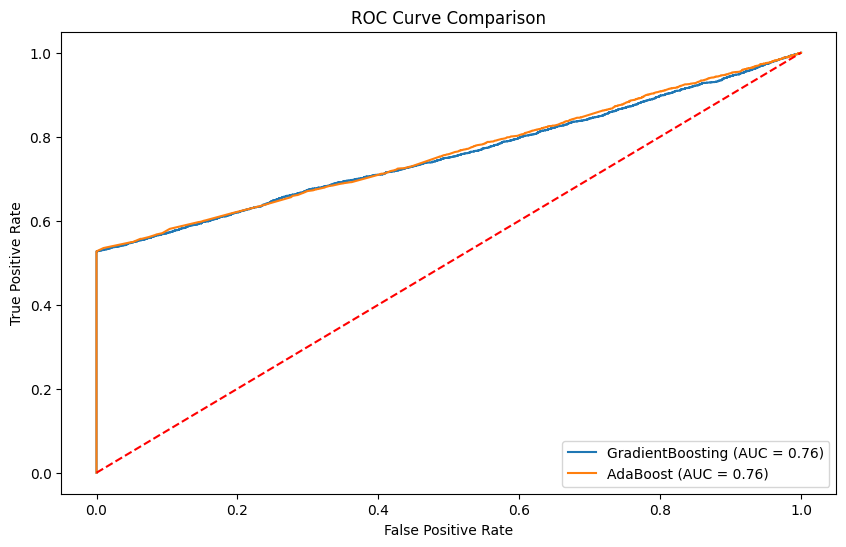

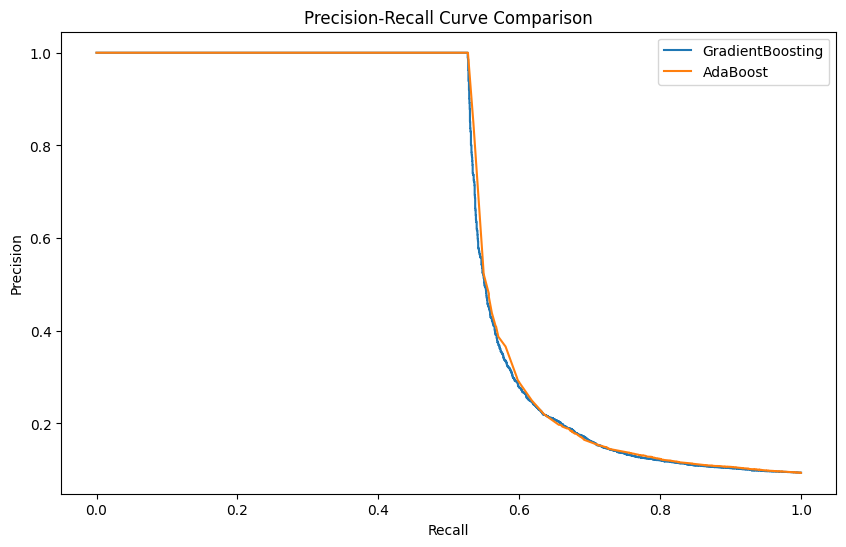

Best Model based on F1-score is: AdaBoost with F1-score: 0.6896232955858562
Accuracy for best model: 0.955563643582702


In [12]:
# 7. Visualization
#-----------------------------------------
df_scores = pd.DataFrame(model_scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
df_scores_melt = df_scores.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Bar plot of metrics
plt.figure(figsize=(10,6))
sns.barplot(data=df_scores_melt, x='Model', y='Score', hue='Metric')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc='best')
plt.show()

# Confusion matrices for each model
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ROC Curves
plt.figure(figsize=(10,6))
for model_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # SVC with probability=True does have predict_proba
        y_proba = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'r--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(10,6))
for model_name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.predict_proba(X_test)[:,1]
    precision_pts, recall_pts, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall_pts, precision_pts, label=model_name)
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

# Determine best model based on F1-score
best_model = max(model_scores, key=lambda x: x[-1])
print("Best Model based on F1-score is:", best_model[0], "with F1-score:", best_model[-1])
print("Accuracy for best model:", best_model[1])